# LADOT one trip - projecting distance for all vp

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd

import create_table
import utils
import neighbor
import compare_utils
from update_vars import (analysis_date, PROJECT_CRS, 
                         OUTPUT_FOLDER, PARTRIDGE_FOLDER)

In [2]:
ladot_key = "cc53a0dbf5df90e3009b9cb5d89d80ba"
trips_to_use = [
    "183-07rmbur",
    "30--wPRGN1uEEG",
    "30-_6WXotLOIF7fc",
    "47-3pbila5j7",
]

loopy_trips_to_use = [
    "183-04u26szx9",
    "30-15t6vxs", 
    "30-0SpZx5QGbqM"
]

trip_filter = [[
    ("trip_id", "in", trips_to_use + loopy_trips_to_use)
]]

In [3]:
stops_projected = create_table.stop_times_projected_calitp_table(
    analysis_date, 
    folder_path = OUTPUT_FOLDER,
    filters = trip_filter
)

    
vp_projected = create_table.vp_projected_table(
    analysis_date,
    folder_path = OUTPUT_FOLDER,
    filters = trip_filter
)   

segments = gpd.read_parquet(
    f"{PARTRIDGE_FOLDER}LADOT/segments.parquet",
    filters = trip_filter
).to_crs(PROJECT_CRS)

/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: invalid value encountered in cardinal_definition_rules (vectorized)
  outputs = ufunc(*inputs)
/opt/conda/lib/python3.11/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: invalid value encountered in cardinal_definition_rules (vectorized)
  outputs = ufunc(*inputs)
/opt/conda/lib/python3.11/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


## What do we need to calculate speed between stop 5 and 6?

Find the speed between stop_sequence 5 and 6.

* For each stop pair (here, defined by `stop_seq_pair`), we grab a subset of the vp that fall between, and calculate speed.
* They can be thought about as groups along a number line. As the bus travels from one stop to the next, there are a grouping of vp that can be used to derive speed, on, and on, and for each trip, we want to repeat it programatically, without knowing the nuances of the start/end numbers of each group.
* The first improvement on this is to actually capture the relevant before/after vp for each stop. Ex: if the bus is seen 10 feet before the stop and also 5 feet after the stop, presumably the bus arrives at the stop (0 feet) somewhere in between those 2 timestamps. 
   * We want to calculate an estimated RT stop arrival because that will help us compare scheduled stop times with RT stop times.

In [4]:
def stops_and_vp_between_two_stops(
    stops_projected,
    vp_projected,
    segments,
    stop_pair: str,
) -> tuple[pd.DataFrame]:
    """
    """
    stops_projected_subset = stops_projected.loc[
        (stops_projected.stop_seq_pair == stop_pair)
    ]
    
    stops_projected_segment = pd.merge(
        segments[["segment_id", "trip_id", 
                  "stop_id1", "stop_id2", "geometry"]
                ].rename(columns = {"geometry": "segment_geometry"}),
        stops_projected_subset,
        on = ["trip_id", "stop_id1", "stop_id2"],
        how = "inner"
    )
    
    # in case there are multiple rows? shouldn't be
    min_stop_meters = stops_projected_subset.stop_meters.min()
    max_stop_meters = stops_projected_subset.subseq_stop_meters.max()
    
    vp_projected_subset = vp_projected.loc[
        (vp_projected.vp_meters >= min_stop_meters) & 
        (vp_projected.vp_meters <= max_stop_meters)
    ]

    return stops_projected_segment, vp_projected_subset

In [5]:
def speed_for_trip(
    stops_projected: gpd.GeoDataFrame,
    vp_projected: gpd.GeoDataFrame,
    segments: gpd.GeoDataFrame
) -> gpd.GeoDataFrame:
    """
    """
    trip_cols = ["schedule_gtfs_dataset_key", "trip_id"]
    vp_grouped = (vp_projected
                  .sort_values(trip_cols + ["location_timestamp_local"])
                  .groupby(trip_cols)
                  .agg({
                      "vp_meters": lambda x: list(x),
                      "location_timestamp_local": lambda x: list(x)}
                  )
                  .reset_index()
                 )

    stops_projected2 = pd.merge(
        stops_projected,
        vp_grouped,
        on = trip_cols,
        how = "inner"
    )
    
    arrival_time_series = []

    for row in stops_projected2.itertuples():
        arrival_time = neighbor.interpolate_stop_arrival_time(
            getattr(row, "stop_meters"), 
            np.array(getattr(row, "vp_meters")),
            np.array(getattr(row, "location_timestamp_local"))
        )
        arrival_time_series.append(arrival_time)
    
    stops_projected2 = stops_projected2.assign(
        arrival_time = arrival_time_series
    )

    stops_projected2 = stops_projected2.assign(
        subseq_arrival_time = (stops_projected2.sort_values(trip_cols + ["stop_sequence"])
                              .groupby(trip_cols)
                              .arrival_time
                              .shift(-1)
                             )
    )
    
    meters_elapsed = stops_projected2.subseq_stop_meters - stops_projected2.stop_meters
    sec_elapsed = (stops_projected2.subseq_arrival_time - 
                    stops_projected2.arrival_time) / np.timedelta64(1, "s")
    speed = utils.calculate_speed(meters_elapsed, sec_elapsed)
    stops_projected2 = stops_projected2.assign(
        speed_mph = speed
    )
    
    drop_cols = ["vp_meters", "location_timestamp_local"]
    
    stops_projected_segment = pd.merge(
        segments[["segment_id", "trip_id", 
                  "stop_id1", "stop_id2", "geometry"]
                ].rename(columns = {"geometry": "segment_geometry"}),
        stops_projected2,
        on = ["trip_id", "stop_id1", "stop_id2"],
        how = "inner"
    ).drop(columns = drop_cols)
    
    return stops_projected_segment

In [6]:
one_trip = trips_to_use[0]

stops_subset, vp_subset = stops_and_vp_between_two_stops(
    stops_projected[stops_projected.trip_id==one_trip], 
    vp_projected[vp_projected.trip_id==one_trip], 
    segments, 
    "5__6"
)

In [7]:
stops_subset

,segment_id,trip_id,stop_id1,stop_id2,segment_geometry,schedule_gtfs_dataset_key,stop_name,geometry,stop_sequence,shape_id,stop_primary_direction,stop_meters,subseq_stop_meters,stop_seq_pair,stop_id_pair
0,6723380-6723381-1,183-07rmbur,6723380,6723381,"LINESTRING (160850.724 -440804.215, 160846.700...",cc53a0dbf5df90e3009b9cb5d89d80ba,Pico Blvd & Santee St,POINT (160850.724 -440804.215),5,26043,Westbound,1304.44698,1597.608502,5__6,6723380__6723381


In [8]:
vp_projected.head()

,schedule_gtfs_dataset_key,trip_id,location_timestamp_local,geometry,shape_id,shape_geometry,vp_primary_direction,vp_meters,vp_idx
0,cc53a0dbf5df90e3009b9cb5d89d80ba,47-3pbila5j7,2024-10-16 06:10:03,POINT (154265.742 -415995.716),2307,"LINESTRING (154359.169 -415987.739, 154432.280...",Unknown,0.0,0
1,cc53a0dbf5df90e3009b9cb5d89d80ba,47-3pbila5j7,2024-10-16 06:10:19,POINT (154265.765 -415997.047),2307,"LINESTRING (154359.169 -415987.739, 154432.280...",Southbound,0.0,1
2,cc53a0dbf5df90e3009b9cb5d89d80ba,47-3pbila5j7,2024-10-16 06:10:39,POINT (154266.247 -415998.260),2307,"LINESTRING (154359.169 -415987.739, 154432.280...",Southbound,0.0,2
3,cc53a0dbf5df90e3009b9cb5d89d80ba,47-3pbila5j7,2024-10-16 06:10:59,POINT (154265.771 -415997.380),2307,"LINESTRING (154359.169 -415987.739, 154432.280...",Northbound,0.0,3
4,cc53a0dbf5df90e3009b9cb5d89d80ba,47-3pbila5j7,2024-10-16 06:11:27,POINT (154265.305 -415997.056),2307,"LINESTRING (154359.169 -415987.739, 154432.280...",Westbound,0.0,4


## Calculate speed and map

In [9]:
speed_gdf = speed_for_trip(stops_projected, vp_projected, segments)

### How did "good" trips vs "loopy" trips do under this method?

We have 3 trips where stops increase monotonically (meters along shape) and 3 trips where it doesn't (meaning some kind of loopy or inlining occurs).

#### Good Trips

We can calculate speeds here. The major performance improvement would be for us to get the same results without scanning all the vehicle positions to get there. If we can get the same results with less, we can comfortably scale up.

#### Loopy Trips

Speeds are mostly null! This happens because we convert geographies into numbers, and we assume the number line behaves. If the `vp_meters` was our x, and progressed like `[0, 5, 10, 15, 20]`, and we ask, what time (y) will you arrive when x=2, we can answer that. But if our x behaves like `[0, 3, 5, 6, 10, 1]`, then it's not so clear where x=2 is (is it between the first 2 points or between the last 2 points)?

Performed poorly, simply because when we take chunks from the number line, if the number line isn't always increasing, we can't take reasonable chunks. If the number line is wavy, going up and down like those sine or cosine curves, we're not able to 

### "Good Trips" Mapped

min speed: 1.634116213630938, max speed: 76.49355172858043
total rows: 100
rows with invalid speeds: 0
rows with valid speeds: 100


<AxesSubplot:>

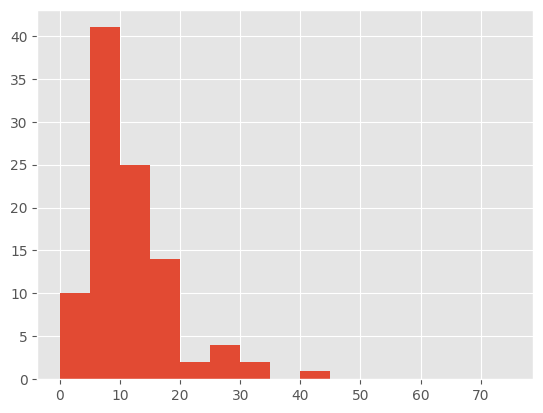

In [10]:
compare_utils.speed_stats(
    speed_gdf[speed_gdf.trip_id.isin(trips_to_use)]
)

In [11]:
compare_utils.speed_map(
    speed_gdf[speed_gdf.trip_id.isin(trips_to_use)]
)

#### Loopy Trips Mapped

min speed: -inf, max speed: inf
total rows: 109
rows with invalid speeds: 35
rows with valid speeds: 74


<AxesSubplot:>

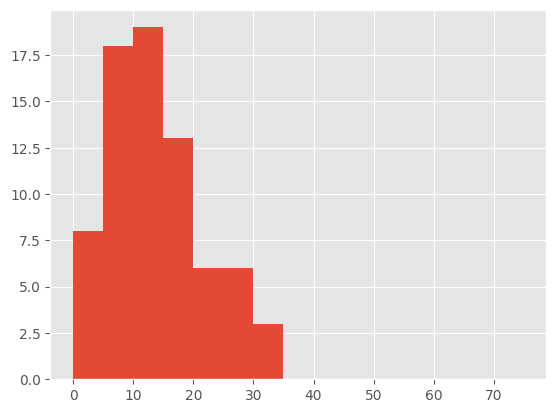

In [12]:
compare_utils.speed_stats(
    speed_gdf[speed_gdf.trip_id.isin(loopy_trips_to_use)]
)

In [13]:
compare_utils.speed_map(
    speed_gdf[speed_gdf.trip_id.isin(loopy_trips_to_use)]
)

## Methodology
* Project each stop position and vehicle position onto shape
* Use that to find distance and time elapsed
* Speed can be calculated between stops

### Real World Complexities
* This one trip, for the most part, it's not that many vp between each stop. Are we saving much time if we filter it out anyway?
   * It depends on the framework of what you use to define a segment.
   * A stop-to-stop segment is fairly finite. But what if we move to corridors? Each city block?
   * If we start combining trips across multiple operators that travel along the same street, how do we go about filtering efficiently without calculating every delta there is, and using only a fraction of those to calculate what we're interested in?
* Ideally, the meters progressed increases monotonically, though that's not true for about 1/3 of the routes where there is loop or inlining occurring. If a bus double backs along any portion of the shape, (going one way along a major street, then back along it; exiting a plaza), then `vp_meters` can actually decrease for a bit without being incorrect.
   * We need an additional data processing step...why `stop_times_direction` was created, we want to know what a stop's primary direction of travel is.
   * We should add something similar to vp.
   * If a vp isn't moving, the `vp_primary_direction="Unknown"`, and actually that helps us get at dwell times too.
   * This is not a dwell time at a stop necessarily, but how many vp observations did we capture without the bus moving (aka traffic). 
   * For a single day, for all operators with RT, this narrows down the rows from 15M to 12M (so that's a nice chunk that we can roll-up!)
   * Nearest neighbors will help us get at this, because we can move to a more stop-agnostic framework. While transit will use stop-to-stop segments, maybe we can also ask what are speeds for transit that travel along a corridor, and use each city block as our segment.
   * The less granular we go, the more we can quickly filter through to find the vp we're most interested in.
   * The more granular we go, eventually we do converge at calculating all the deltas.